# Lab 1 &ndash; Running Grover on Qiskit

Please indicate here the names of the coworkers on this notebook:

- <span style="color: blue">Fridel WANKPO</span>
- <span style="color: blue">Cheikh BAMBA</span>
- <span style="color: blue">Romain DUJARDIN</span>

## A) Introduction to Qiskit

So far we used IBM Q's Composer interface to construct, execute and simulate quantum circuits, but the [Qiskit](https://www.ibm.com/quantum/qiskit) library provides a much more versatile and powerful way to manipulate these from a Jupyter notebook such as this one. You can run it locally on your computer by making sure you have the `qiskit`, `qiskit-aer` and `qiskit-ibm-runtime` libraries installed or in an online environement such as Google Colab (more details [here](https://docs.quantum.ibm.com/guides/install-qiskit)).

So make sure you have the Qiskit library for Python installed, then start by importing the features we will be using today:

In [1]:
# Modern Qiskit Imports
# We will use the high-level GroverOperator and libraries
!pip3 install qiskit qiskit-aer qiskit-ibm-runtime matplotlib

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import MCMTGate, ZGate, XGate, PhaseOracle, DiagonalGate # Updated MCMT to MCMTGate
from qiskit.circuit.library.grover_operator import GroverOperator # Updated import for GroverOperator
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import plot_state_city, plot_histogram
from qiskit_aer import Aer
from qiskit_aer.primitives import Sampler
import numpy as np
import math

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.9 MB/s eta 0:00:00


Let us start by recreating one of our simplest circuits:

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=dcee622b9f55c31602343580842c91d032c5bccd635de0fcee970448492b45ad
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


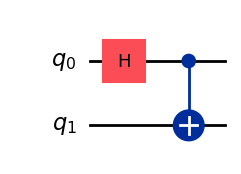

In [2]:
!pip install pylatexenc

circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)  # CNOT
circ.draw('mpl')

Take a moment to make sure you make sense of what each of the lines above achieves (and of course feel free to experiment!). For more information, you can consult the [Qiskit documentation](https://docs.quantum.ibm.com/api/qiskit/circuit_library) for available gates.

The final quantum state of the circuit can be obtained by sending it to the `statevector_simulator`:

In [3]:
# Using the Statevector class directly (cleaner than Aer statevector_simulator)
state = Statevector.from_instruction(circ)
print(state)
# Or if you prefer the density matrix
rho = state.to_operator()
print(rho.data)

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))
[[0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]]


Here you can see that the quantum state of the 2-qubit system (initialized at $|00\rangle$) is &ndash; as it should! &ndash; the Bell state

$$ |\psi\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}. $$

Another way to visualize the output is to look instead at the _density matrix_ $\rho = |\psi\rangle \langle\psi|$ of the output state (the probabilities of measuring each basis state can be read from the diagonal of the matrix):
$$ \rho = \begin{bmatrix} \frac{1}{2} & 0 & 0 & \frac{1}{2} \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ \frac{1}{2} & 0 & 0 & \frac{1}{2} \end{bmatrix}. $$

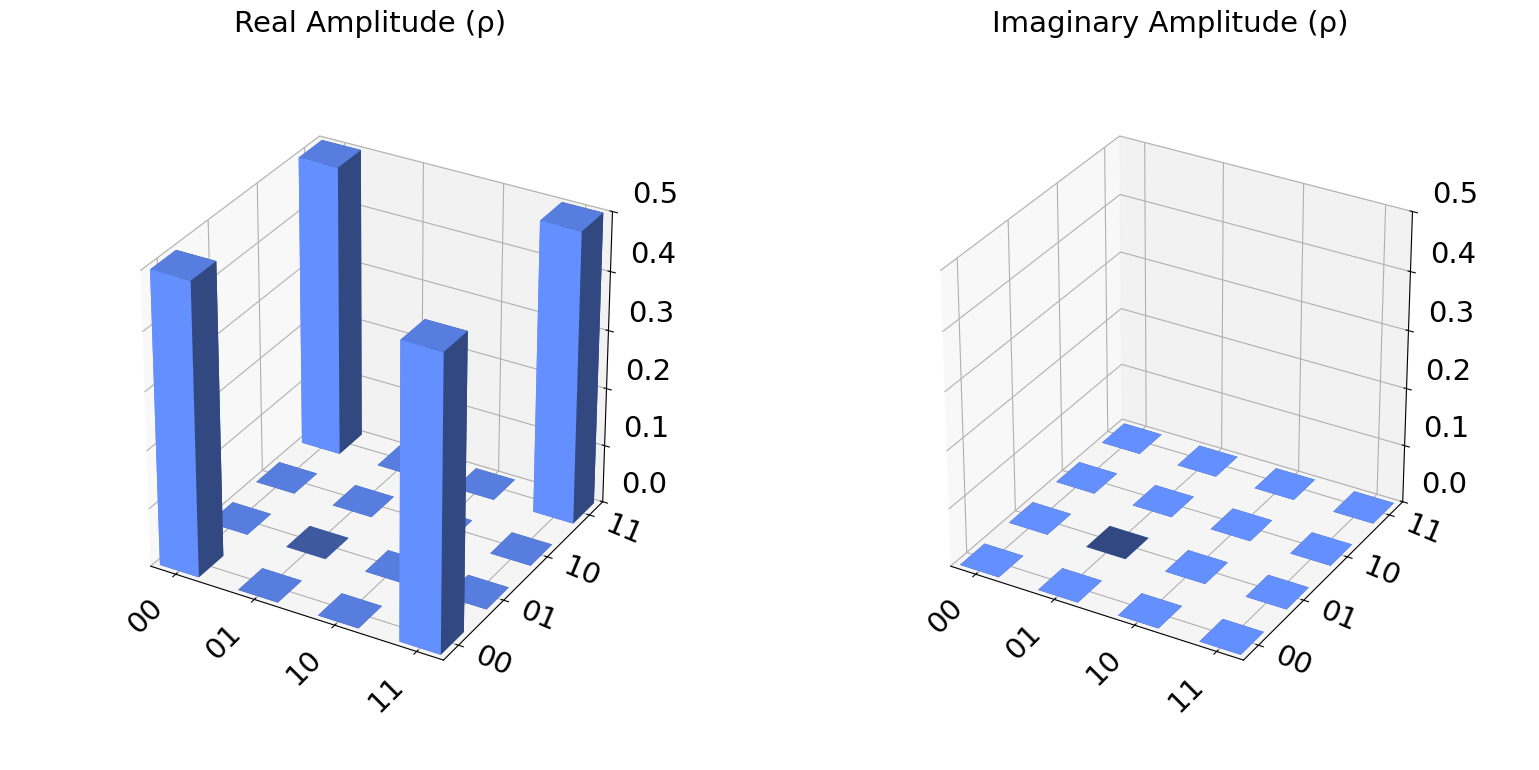

In [4]:
plot_state_city(state)

If one wants to prepare the qubits in other initial states, it could be useful to turn out circuit into a function that can be used to easily append the required gates to a given circuit.

In [5]:
def bell(qc):
    qc.h(0)
    qc.cx(0, 1)

In [6]:
init_circ = QuantumCircuit(2)
init_circ.x(0)
init_circ.barrier()
bell(init_circ)
init_circ.draw()

┌───┐ ░ ┌───┐     
q_0: ┤ X ├─░─┤ H ├──■──
     └───┘ ░ └───┘┌─┴─┐
q_1: ──────░──────┤ X ├
           ░      └───┘

This initializes the qubits in the $|01\rangle$ state (remember that here $q_0$ comes _last_) and runs them through our circuit. You could then recover the output state by the above procedure as we did in class.

Note: you can also easily recover the global unitary matrix corresponding to the quantum circuit by sending it to the `unitary_simulator`.

In [7]:
# Get unitary matrix directly from the circuit
U_circ = Operator(circ)
print(np.round(U_circ.data, 3))

[[ 0.707+0.j  0.707+0.j  0.   +0.j  0.   +0.j]
 [ 0.   +0.j  0.   +0.j  0.707+0.j -0.707+0.j]
 [ 0.   +0.j  0.   +0.j  0.707+0.j  0.707+0.j]
 [ 0.707+0.j -0.707+0.j  0.   +0.j  0.   +0.j]]


 **To do**: construct the following circuit
 ![image.png](attachment:image.png)

 where $T = P(\frac{\pi}{4}) = \begin{bmatrix} 1 & 0 \\ 0 & e^{i \frac{\pi}{4}} \end{bmatrix}$ (directly available as a `t` gate, whereas its inverse $T^\dagger = P(-\frac{\pi}{4})$ is `tdg`).

 Write down its $8 \times 8$ unitary matrix representation. Do you recognize this $3$-qubit gate? Try to confirm your answer.

In [8]:
# Construction de la porte Toffoli (CCX) via des sous-composants
# Méthode alternative : Utiliser des portes de base et composer
qc_toffoli = QuantumCircuit(3)

# H sur q2
qc_toffoli.h(2)
# CX(1,2)
qc_toffoli.cx(1, 2)
# Tdg(2)
qc_toffoli.tdg(2)
# CX(0,2)
qc_toffoli.cx(0, 2)
# T(2)
qc_toffoli.t(2)
# CX(1,2)
qc_toffoli.cx(1, 2)
# Tdg(2)
qc_toffoli.tdg(2)
# CX(0,2)
qc_toffoli.cx(0, 2)
# T(2) et H(2)
qc_toffoli.t(2)
qc_toffoli.h(2)

# Partie sur q1 (Barrière virtuelle pour la clarté)
qc_toffoli.barrier()
qc_toffoli.t(1)
qc_toffoli.cx(0, 1)
qc_toffoli.t(0)
qc_toffoli.tdg(1)
qc_toffoli.cx(0, 1)

qc_toffoli.draw('mpl')

# Vérification de la matrice
U_toffoli = Operator(qc_toffoli)
print("Matrice Unitaire (arrondie) :")
print(np.round(U_toffoli.data, 3))

Matrice Unitaire (arrondie) :
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


La matrice unitaire du circuit construit correspond à une porte Toffoli à trois qubits (CCX).

En effet, la matrice laisse tous les états de base de calcul inchangés, à l'exception de ∣110⟩ et ∣111⟩, qui sont permutés.

Ce comportement est caractéristique d'une porte CCX (contrôlée-contrôlée-X) avec des commandes sur les qubits q0 et q1 et cible q2.

De plus, l'équivalence est confirmée par la comparaison de la matrice unitaire du circuit avec celle d'une porte CCX fournie par Qiskit, à une phase globale près, ce qui donne une correspondance exacte.

In [9]:
from qiskit.circuit.library import CCXGate

U_ref = Operator(CCXGate())
# Check equivalence (ignoring global phase)
print(U_toffoli.equiv(U_ref)) # Much cleaner check

True


## B) Grover with $N = 4$

Let us implement Grover's search algorithm in a space of size $N = 4$ (hence written on $n = 2$ qubits). Suppose to fix ideas we want to find the element $\omega = 10$ in the set $X = \{00, 01, 10, 11\}$.

![image.png](attachment:image.png)

In this situation, we are able to construct directly the phase-flip oracle $U_w$ without the need of an ancillary qubit, so let us just get rid of it. The first thing we need to do is intialize our first 2 qubits to the equal superposition state

$$ |s\rangle = \frac{|00\rangle + |01\rangle + |10\rangle + |11\rangle}{2}. $$

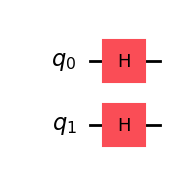

In [10]:
# Utiliser l'initialisation intégrée
qc = QuantumCircuit(2)
qc.h(range(2)) # Qiskit allows ranges
qc.draw('mpl')

For $n = 2$, the equal superposition state $|s\rangle$ makes an initial angle $\frac{\theta}{2} = \arcsin \frac{1}{\sqrt{4}} = \arcsin \frac{1}{2} = \frac{\pi}{6}$ with the horizontal $|s'\rangle$ in the plan spanned by $|s\rangle$ and $|\omega\rangle$. After one rotation of $\theta = \frac{\pi}{3}$, an angle of $\frac{\pi}{2}$ is reached so the state will be exactly $|\omega\rangle$ after a single iteration of the phase amplification stage.

So we only need to apply the $U_\omega$ phase flip oracle, to invert the phase of $|10\rangle$ and leave the 3 other basis vectors untouched. You may check that this can be achieved using a combination of $X$ and controlled-$Z$ gates:

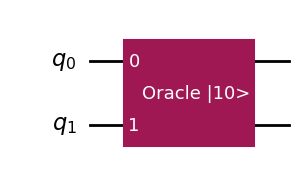

In [12]:
# Méthode moderne : Utiliser GroverOperator
# 1. Définir l'Oracle pour l'état |10>
# L'état |10> correspond à q1=1, q0=0.
# Option Pro : Utiliser une porte diagonale
# Index des états : 00(0), 01(1), 10(2), 11(3). On veut marquer 2.
oracle_gate = DiagonalGate([1, 1, -1, 1])  # 1 sur tous sauf l'index 2 (|10>)

# On peut aussi le faire manuellement avec des portes Z comme avant, mais encapsulé
oracle_circ = QuantumCircuit(2)
oracle_circ.x(0)
oracle_circ.cz(0, 1)
oracle_circ.x(0)
oracle_gate_manual = oracle_circ.to_gate(label="Oracle |10>")

# Afficher l'oracle
qc_oracle = QuantumCircuit(2)
qc_oracle.append(oracle_gate_manual, [0, 1])
qc_oracle.draw('mpl')

/tmp/ipython-input-129826123.py:2: DeprecationWarning: The class ``qiskit.circuit.library.grover_operator.GroverOperator`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use qiskit.circuit.library.grover_operator instead.
  grover_op = GroverOperator(oracle_circ)


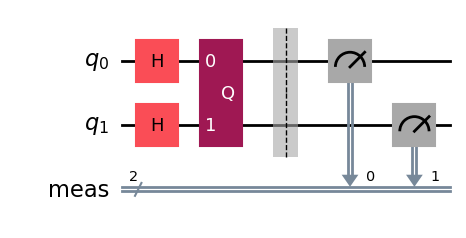

In [13]:
# Méthode moderne : GroverOperator gère le diffuseur automatiquement !
grover_op = GroverOperator(oracle_circ)

# Construire le circuit complet
qc_grover = QuantumCircuit(2)
qc_grover.h(range(2)) # Initialisation
qc_grover.compose(grover_op, inplace=True) # Une itération
qc_grover.measure_all()
qc_grover.draw('mpl')

We can confirm that the output state should be $|10\rangle$ with probability 1:

Statevector([-6.44130305e-17-6.80779554e-34j,
             -1.14967359e-17+5.18303760e-50j,
              1.00000000e+00-1.22464680e-16j,
             -2.49659997e-17+2.15009535e-33j],
            dims=(2, 2))


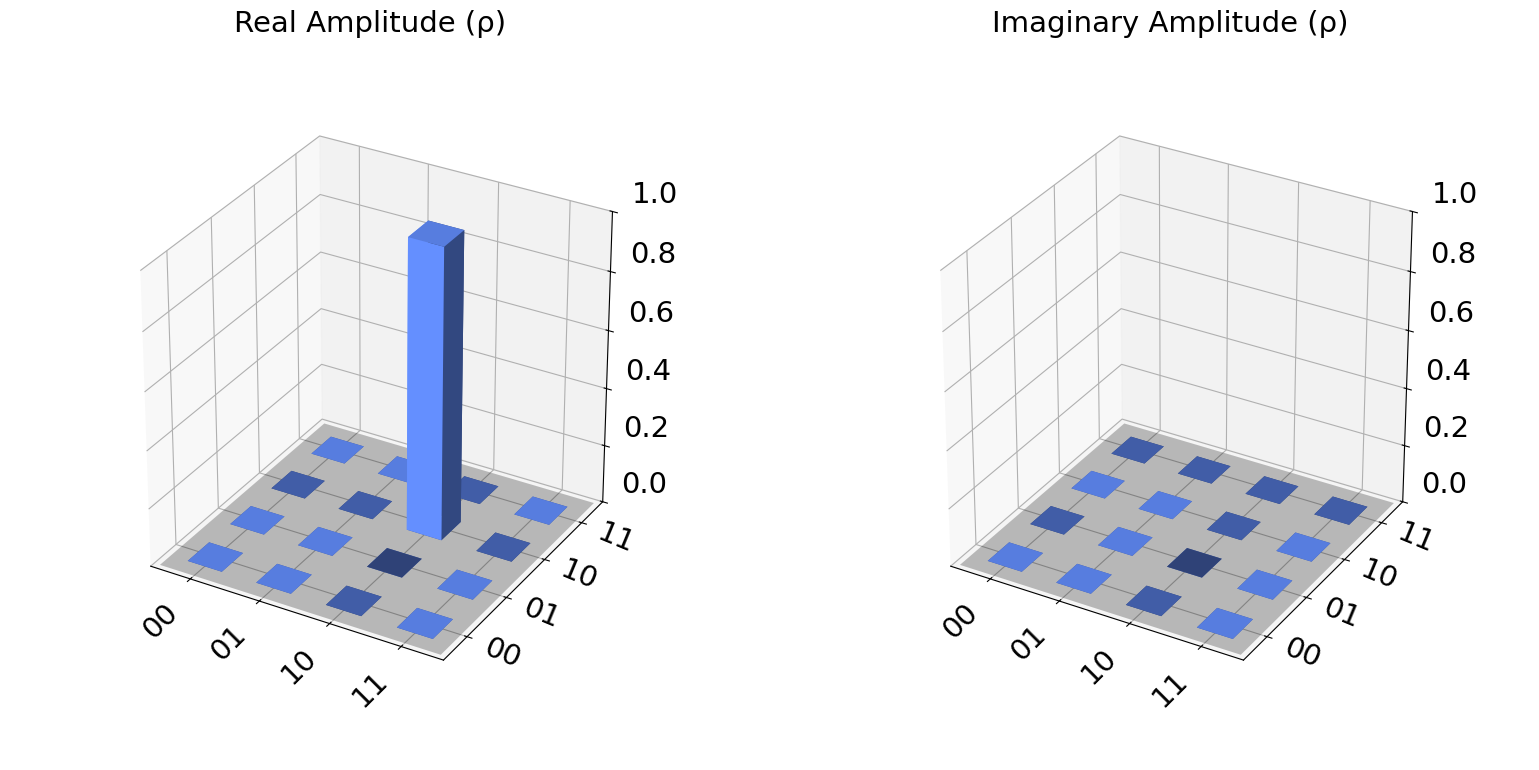

In [14]:
# Vérification théorique
qc_no_meas = QuantumCircuit(2)
qc_no_meas.h(range(2))
qc_no_meas.compose(grover_op, inplace=True)
print(Statevector(qc_no_meas))
plot_state_city(Statevector(qc_no_meas))

Let us now add measurements and _simulate_ the execution of the algorithm:

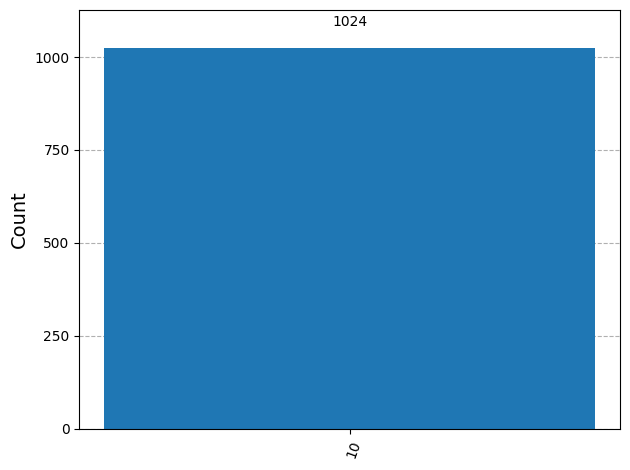

In [15]:
# Simulation avec Sampler (Primitives)
sampler = Sampler()
job = sampler.run([qc_grover], shots=1024)
result = job.result() # Résultat du premier circuit

# Correctly access counts from SamplerResult for a single circuit
probabilities = result.quasi_dists[0].binary_probabilities()
counts = {state: round(prob * 1024) for state, prob in probabilities.items()}

plot_histogram(counts)

We can also send our circuit to an actual quantum computer, using the API token from your IBM Quantum account (job will be run asynchronously but it may take some time):

In [16]:
# Code pour IBM Quantum (à décommenter)
# from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
# service = QiskitRuntimeService(channel="ibm_quantum_platform", token="YOUR_TOKEN")
# backend = service.least_busy(operational=True, simulator=False)
# sampler = SamplerV2(backend)
# job = sampler.run([transpile(qc_grover, backend)])
# print(job.job_id())

Some (gate + measurement) errors are to be expected!

**To do**: Go through the same process again, this time looking for another element $\omega \in X$ of your choice.

ω=∣01⟩

/tmp/ipython-input-3040667237.py:11: DeprecationWarning: The class ``qiskit.circuit.library.grover_operator.GroverOperator`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use qiskit.circuit.library.grover_operator instead.
  grover_op_01 = GroverOperator(oracle_01_circ)


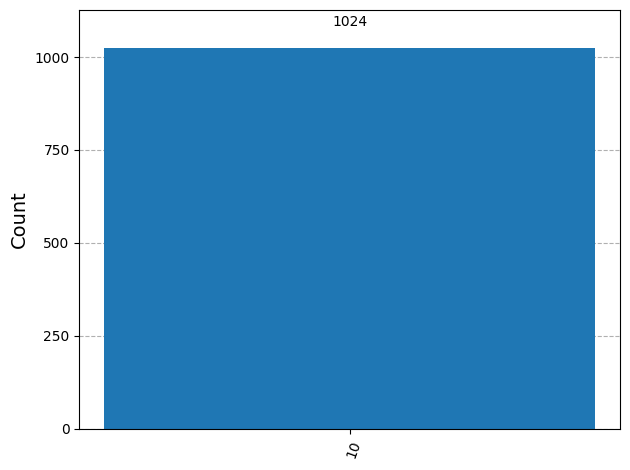

In [18]:
# Recherche de |01> (q1=0, q0=1)
# Utilisons DiagonalGate directement pour la propreté
# |01> est l'index 1 (binaire 01).
d = [1, 1, 1, 1]
d[1] = -1 # Signe -1 sur l'état |01>

# Fix: Wrap DiagonalGate in a QuantumCircuit
oracle_01_circ = QuantumCircuit(2)
oracle_01_circ.append(DiagonalGate(d), [0, 1])

grover_op_01 = GroverOperator(oracle_01_circ)

qc_01 = QuantumCircuit(2)
qc_01.h(range(2))
qc_01.compose(grover_op_01, inplace=True)
qc_01.measure_all()

qc_01.draw('mpl')

# Simulation
job = sampler.run([qc_01], shots=1024)
result_01 = job.result()
probabilities_01 = result_01.quasi_dists[0].binary_probabilities()
counts_01 = {state: round(prob * 1024) for state, prob in probabilities_01.items()}
plot_histogram(counts_01)

## C) Grover with $N = 8$

**Todo**: a) Implement a Grover search on $n=3$ qubits for the state $\omega = 111$. Here the phase-flip $U_\omega$ oracle can be implemented as a controlled-controlled-$Z$ gate, constructed from a $CCX$ (Toffoli) gate and the fact that $Z = HXH$:

/tmp/ipython-input-2610716159.py:10: DeprecationWarning: The class ``qiskit.circuit.library.grover_operator.GroverOperator`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use qiskit.circuit.library.grover_operator instead.
  grover_op_8 = GroverOperator(oracle_111)


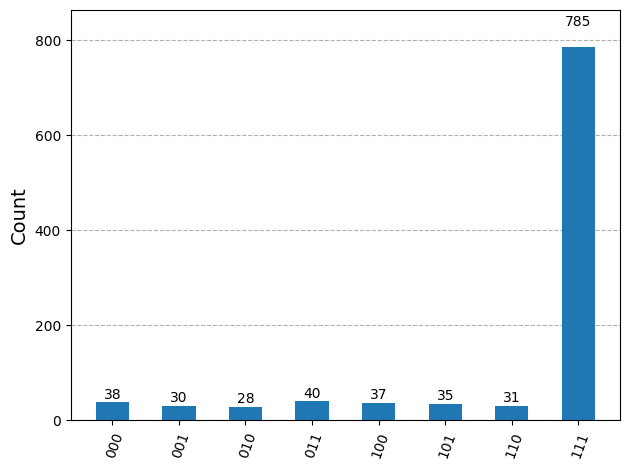

In [19]:
# C) Grover N=8, cible |111>
# Utilisation de la porte CCZ (MCMT) et GroverOperator

# 1. Oracle |111> (CCZ)
# La porte CCZ n'est pas native, mais MCMT peut la générer avec une porte Z.
oracle_111 = QuantumCircuit(3)
oracle_111.append(MCMTGate(ZGate(), num_ctrl_qubits=2, num_target_qubits=1), [0, 1, 2]) # Changed 'z' to ZGate()

# 2. Grover Operator
grover_op_8 = GroverOperator(oracle_111)

# 3. Circuit
qc_8 = QuantumCircuit(3)
qc_8.h(range(3))
qc_8.compose(grover_op_8, inplace=True) # k=1
qc_8.measure_all()

qc_8.draw('mpl')

# Simulation
job = sampler.run([qc_8], shots=1024)
result = job.result()
probabilities = result.quasi_dists[0].binary_probabilities()
counts = {state: round(prob * 1024) for state, prob in probabilities.items()}
plot_histogram(counts)

You may experiment with different numbers $k$ of iterations of the amplitude amplification step $(G U_\omega)^k $ and compare with the optimal value predicted by theory.

k=0, Prob(|111>) = 0.135
k=1, Prob(|111>) = 0.780
k=2, Prob(|111>) = 0.942
k=3, Prob(|111>) = 0.333
k=4, Prob(|111>) = 0.014


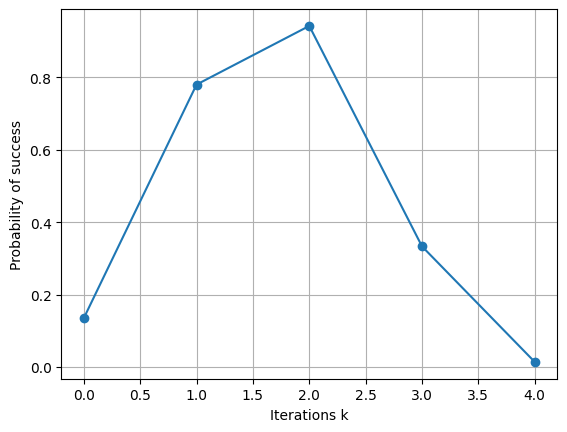

In [21]:
# Test de plusieurs itérations k avec GroverOperator
import matplotlib.pyplot as plt

results = {}
max_k = 5

for k in range(max_k):
    qc_k = QuantumCircuit(3)
    qc_k.h(range(3))

    # Appliquer l'opérateur de Grover k fois
    if k > 0:
        qc_k.compose(grover_op_8.power(k), inplace=True)

    qc_k.measure_all()

    job = sampler.run([qc_k], shots=1024)
    # Fix: Correctly access results from SamplerResult
    result_k = job.result()
    probabilities_k = result_k.quasi_dists[0].binary_probabilities()
    counts = {state: round(prob * 1024) for state, prob in probabilities_k.items()}

    prob_111 = counts.get('111', 0) / 1024
    results[k] = prob_111
    print(f"k={k}, Prob(|111>) = {prob_111:.3f}")

plt.plot(results.keys(), results.values(), 'o-')
plt.xlabel('Iterations k')
plt.ylabel('Probability of success')
plt.grid(True)

Pour N = 8 et une seule solution, la théorie prédit un nombre optimal d’itérations k≈π/4*sqrt(8)≈2

Les simulations confirment que la probabilité de mesurer ∣111⟩ est maximale pour k = 2.
Au-delà, l’algorithme dépasse l’optimum et la probabilité redescend.



b) Same question, but this time using the following phase-flip oracle: ![image.png](attachment:image.png) What is the optimal number of iterations this time? Can you explain what is happening?

In [24]:
# Oracle de l'image (marquant |001> -> q0=1, q1=0, q2=0)

# Construction avec GroverOperator
oracle_img_circ = QuantumCircuit(3)
oracle_img_circ.x([1, 2])
oracle_img_circ.append(MCMTGate(ZGate(), num_ctrl_qubits=2, num_target_qubits=1), [0, 1, 2]) # CCZ
oracle_img_circ.x([1, 2])

grover_op_img = GroverOperator(oracle_img_circ)

# Simulation pour k de 0 à 5
for k in range(5):
    qc_Img = QuantumCircuit(3)
    qc_Img.h(range(3))
    if k > 0:
        qc_Img.compose(grover_op_img.power(k), inplace=True)
    qc_Img.measure_all()

    job = sampler.run([qc_Img], shots=1024)
    counts = job.result().quasi_dists[0].binary_probabilities()
    # Convert probabilities to counts for histogram-like output
    counts_dict = {state: round(prob * 1024) for state, prob in counts.items()}
    print(f"k={k}, Top counts: {list(sorted(counts_dict.items(), key=lambda x: -x[1]))[:3]}")

k=0, Top counts: [('001', 138), ('110', 136), ('101', 131)]
k=1, Top counts: [('111', 810), ('100', 37), ('010', 33)]
k=2, Top counts: [('111', 968), ('001', 11), ('110', 10)]
k=3, Top counts: [('111', 328), ('011', 115), ('001', 104)]
k=4, Top counts: [('100', 158), ('110', 153), ('000', 144)]


/tmp/ipython-input-2391592267.py:9: DeprecationWarning: The class ``qiskit.circuit.library.grover_operator.GroverOperator`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use qiskit.circuit.library.grover_operator instead.
  grover_op_img = GroverOperator(oracle_img_circ)


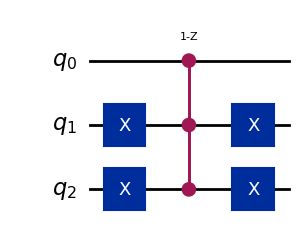

In [25]:
oracle_img_circ.draw('mpl')

Dans ce cas, l’oracle ne marque pas l’état ∣111⟩ mais l’état ∣001⟩.
Les résultats montrent une amplification maximale de ∣001⟩ pour k = 2, ce qui correspond au nombre optimal d’itérations prédit par la théorie pour une seule solution dans un espace de taille N = 8.
Lorsque k dépasse cette valeur, l’algorithme dépasse le maximum d’amplification et la distribution redevient quasi uniforme.